In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def load_data(file_path):
    """Load data from an Excel file and adjust the DataFrame index."""
    data = pd.read_excel(file_path)
    data.index = data.index + 1  # Shift index to start from 1
    return data

In [3]:
def calculate_duty_and_flux(dataframe):
    """Calculate duty and flux for each stream and add as new columns to the DataFrame."""
    duties = []
    fluxes = []
    for i in range(1, len(dataframe) + 1):
        duty_kj_hr = dataframe['Cp (kJ/kmol/K)'][i] * dataframe['T_diff'][i] * dataframe['Molar Flow Rate [kmol/hr]'][i]
        duty_kw = duty_kj_hr / 3600  # Convert to kW
        flux_kw_k = duty_kw / dataframe['T_diff'][i]

        duties.append(duty_kw)
        fluxes.append(flux_kw_k)

    dataframe['Duty [kW]'] = duties
    dataframe['Flux [kW / K]'] = fluxes
    return dataframe

In [4]:
# Load the stream data
stream_data = load_data('streams/AEStreamTable2.xlsx')

# Calculate duty and flux and update the DataFrame
updated_stream_data = calculate_duty_and_flux(stream_data)

updated_stream_data

,Stream Number,Type,Molar Flow Rate [kmol/hr],Tin,Tout,T_diff,Cp (kJ/kmol/K),Duty [kW],Flux [kW / K]
1,S2,cold,162.598652,93.790304,150.000000,-56.209696,175.453272,-445.437877,7.924574
2,S9,cold,309.317662,124.850263,619.999892,-495.149629,226.374457,-9630.882812,19.450449
3,S11,cold,256.000000,20.000000,620.000000,-600.000000,29.584853,-1262.287059,2.103812
4,S12,hot,575.347324,620.000000,2.000000,618.000000,124.000000,12247.226712,19.817519
5,S15,cold,158.352029,0.547123,150.000000,-149.452877,150.560459,-989.774681,6.622654
6,S21,cold,500.000000,20.000000,150.000000,-130.000000,29.089416,-525.225564,4.040197
7,S22,hot,337.018246,150.000000,25.000000,125.000000,139.855395,1636.590970,13.092728
8,S24,hot,322.000000,25.000000,23.100976,1.899024,149.396949,25.376144,13.362727
9,S25,cold,7.497616,24.999994,150.000000,-125.000006,29.392114,-7.651764,0.061214
10,S27,cold,215.715500,20.000000,100.000000,-80.000000,199.685133,-957.226184,11.965327


In [5]:
def map_stream_to_index(dataframe):
    """Create a mapping from stream names to their indices."""
    return {stream: idx + 1 for idx, stream in enumerate(dataframe['Stream Number'])}


In [6]:
def replace_streams_with_indices(streams_in_intervals, stream_to_index):
    """
    Replace stream names in the intervals with their corresponding indices.
    
    Args:
    streams_in_intervals: Dictionary of intervals with stream names.
    stream_to_index: Mapping of stream names to indices.

    Returns:
    Dictionary with intervals and corresponding stream indices.
    """
    new_intervals = {}
    for interval, streams in streams_in_intervals.items():
        new_intervals[interval] = [stream_to_index.get(str(stream), stream) for stream in streams]
    return new_intervals

In [7]:
def create_delta_matrix(num_intervals, num_streams, streams_in_intervals, stream_to_index):
    """Create a matrix indicating which streams are in each interval."""
    delta_matrix = np.zeros((num_intervals, num_streams))
    for interval, streams in streams_in_intervals.items():
        for stream in streams:
            stream_idx = stream_to_index[stream] - 1
            delta_matrix[interval - 1, stream_idx] = 1
    return delta_matrix

In [8]:
def calculate_utilities_for_intervals(dataframe, temp_differences_intervals, new_streams_in_intervals, utility_type):
    """
    Calculate utilities for intervals based on utility type (hot/cold).
    
    Args:
    dataframe: DataFrame containing stream data.
    temp_differences_intervals: Temperature differences per interval.
    new_streams_in_intervals: Streams mapped to intervals.
    utility_type: Type of utility to calculate ('hot' or 'cold').

    Returns:
    Dictionary of utility values per interval.
    """
    utility_results = {}
    for interval, streams in new_streams_in_intervals.items():
        total_utility = 0
        for stream_number in streams:
            if dataframe['Type'][stream_number] == utility_type:
                total_utility += dataframe['Flux [kW / K]'][stream_number] * temp_differences_intervals[interval]
        utility_results[interval] = total_utility
    return utility_results

In [9]:
df = updated_stream_data.copy()

# Define your intervals and temperature differences here
num_intervals = 20
num_streams = 14

# Define streams_in_intervals and temp_differences_intervals as per your data
streams_in_intervals = {
    1: ['S9', 'S11'],
    2: ['S12', 'S9', 'S11'],
    3: ['S12', 'S2', 'S9', 'S11', 'S15', 'S21', 'S25'],
    4: ['S22', 'S12', 'S2', 'S9', 'S11', 'S15', 'S21', 'S25'],
    5: ['S22', 'S12', 'S2', 'S11', 'S15', 'S21', 'S25'],
    6: ['S22', 'S12', 'S2', 'S11', 'S15', 'S21', 'S25', 'S27'],
    7: ['S22', 'S12', 'S2', 'S28', 'S11', 'S15', 'S21', 'S25', 'S27'],
    8: ['S22', 'S12', 'S2', 'S28', 'S11', 'S15', 'S21', 'S25', 'S27'],
    9: ['S37', 'S22', 'S12', 'S28', 'S11', 'S15', 'S21', 'S25', 'S27'],
    10: ['S37', 'S22', 'S12', 'S28', 'S29', 'S11', 'S15', 'S21', 'S25', 'S27'],
    11: ['S37', 'S22', 'S12', 'S28', 'S29', 'S11', 'S15', 'S21', 'S25', 'S27', 'S32'],
    12: ['S22', 'S12', 'S28', 'S29', 'S11', 'S15', 'S21', 'S25', 'S27', 'S32'],
    13: ['S22', 'S12', 'S28', 'S11', 'S15', 'S21', 'S25', 'S27', 'S32'],
    14: ['S22', 'S12', 'S28', 'S11', 'S15', 'S21', 'S25', 'S27', 'S32'],
    15: ['S22', 'S12', 'S11', 'S15', 'S21', 'S27', 'S32'],
    16: ['S22', 'S12', 'S15', 'S32'],
    17: ['S22', 'S12', 'S15'],
    18: ['S24', 'S12', 'S15'],
    19: ['S12', 'S15'],
    20: ['S12'],
}

temp_differences_intervals = {
    1: 630-620, 
    2: 620-160, 
    3: 160-150, 
    4: 150-135, 
    5: 135-110, 
    6: 110-106, 
    7: 106-104, 
    8: 104-96, 
    9: 96-94, 
    10: 94-90, 
    11: 90-80, 
    12: 80-72, 
    13: 72-66, 
    14: 66-35, 
    15: 35-30,
    16: 30-26, 
    17: 26-25, 
    18: 25-23, 
    19: 23-10.55, 
    20: 10.55-2
}

stream_to_index = map_stream_to_index(df)
new_streams_in_intervals = replace_streams_with_indices(streams_in_intervals, stream_to_index)
delta_matrix = create_delta_matrix(num_intervals, num_streams, streams_in_intervals, stream_to_index)

hot_utilities = calculate_utilities_for_intervals(df, temp_differences_intervals, new_streams_in_intervals, 'hot')
cold_utilities = calculate_utilities_for_intervals(df, temp_differences_intervals, new_streams_in_intervals, 'cold')
# temp_differences_intervals

In [10]:
hot_utilities

{1: 0,
 2: 9116.058717715556,
 3: 198.17518951555556,
 4: 493.65370065051127,
 5: 822.756167750852,
 6: 131.64098684013635,
 7: 65.82049342006817,
 8: 263.2819736802727,
 9: 74.03208739308401,
 10: 148.06417478616802,
 11: 370.16043696542005,
 12: 263.2819736802727,
 13: 197.4614802602045,
 14: 1020.2176480110566,
 15: 164.55123355017042,
 16: 131.64098684013635,
 17: 32.91024671003409,
 18: 66.36049202366667,
 19: 246.72811094686665,
 20: 169.4397870358}

In [11]:
cold_utilities

{1: 215.5426116856992,
 2: 9914.960137542163,
 3: 402.02899598345766,
 4: 603.0434939751864,
 5: 518.8112548599515,
 6: 130.87110996039047,
 7: 77.41663606370491,
 8: 309.66654425481966,
 9: 61.567488590843865,
 10: 147.62408854101102,
 11: 381.22998099041257,
 12: 304.98398479233003,
 13: 192.00432155526258,
 14: 992.0223280355234,
 15: 129.7448280487723,
 16: 31.35851961439738,
 17: 6.622653939810845,
 18: 13.24530787962169,
 19: 82.452041550645,
 20: 0}

In [12]:
Qj_results = [hot_utilities[i] - cold_utilities[i] for i in range(1, len(hot_utilities)+1)]

In [13]:
Qj_results

[-215.5426116856992,
 -798.9014198266068,
 -203.8538064679021,
 -109.38979332467511,
 303.94491289090047,
 0.7698768797458797,
 -11.596142643636739,
 -46.384570574546956,
 12.464598802240147,
 0.4400862451570049,
 -11.069544024992524,
 -41.702011112057335,
 5.457158704941918,
 28.195319975533153,
 34.80640550139813,
 100.28246722573897,
 26.28759277022324,
 53.115184144044974,
 164.27606939622166,
 169.4397870358]

In [14]:
data = {
    "Interval (i)": [i for i in range(1, 21)],
    "Hot utility [kW]": list(hot_utilities.values()),
    "Cold utility [kW]": list(cold_utilities.values()),
    "Net utility [kW]": list(Qj_results),
    "Surplus or Deficit": list(["Surplus" if Qj_results[i] > 0 else "deficit" for i in range(20)])
}

In [15]:
df1 = pd.DataFrame(data)
df1.index = df1.index + 1

In [16]:
df1

,Interval (i),Hot utility [kW],Cold utility [kW],Net utility [kW],Surplus or Deficit
1,1,0.000000,215.542612,-215.542612,deficit
2,2,9116.058718,9914.960138,-798.901420,deficit
3,3,198.175190,402.028996,-203.853806,deficit
4,4,493.653701,603.043494,-109.389793,deficit
5,5,822.756168,518.811255,303.944913,Surplus
6,6,131.640987,130.871110,0.769877,Surplus
7,7,65.820493,77.416636,-11.596143,deficit
8,8,263.281974,309.666544,-46.384571,deficit
9,9,74.032087,61.567489,12.464599,Surplus
10,10,148.064175,147.624089,0.440086,Surplus


In [17]:
# Minimum cooling requirements
df6 = df1[df1['Interval (i)'] > 4].copy()

df6['Cumulative Utility [kW]'] = df6['Net utility [kW]'].cumsum()

print(f"Minimum cooling requirement: {df6['Cumulative Utility [kW]'][20]} [kW]")

Minimum cooling requirement: 788.727191216712 [kW]


In [18]:
def prepare_hot_enthalpy_data(dfx, tmp_hot):
    """
    Prepare enthalpy data for hot utility from a DataFrame.
    
    Args:
    df: DataFrame containing hot utility values and temperatures.

    Returns:
    DataFrame with cumulative hot utility values and temperatures.
    """
    # Reverse the order of hot utility and calculate cumulative utility
    reversed_hot_utility = list(reversed(dfx['Hot utility [kW]'].tolist()))
    reversed_hot_utility.insert(0, 0)  # Add 0 utility at the start
    df_hot = pd.DataFrame({"Cumulative Utility [kW]": reversed_hot_utility, "Temperature": tmp_hot})
    df_hot['Cumulative Utility [kW]'] = df_hot['Cumulative Utility [kW]'].cumsum()
    return df_hot

In [19]:
def prepare_cold_enthalpy_data(dfx, min_cooling_requirement, tmp_cold):
    """
    Prepare enthalpy data for cold utility from a DataFrame.
    
    Args:
    df: DataFrame containing cold utility values and temperatures.
    min_cooling_requirement: Minimum cooling requirement for the 0th interval.

    Returns:
    DataFrame with cumulative cold utility values and temperatures.
    """
    # Reverse the order of cold utility, add minimum cooling requirement at the start
    reversed_cold_utility = list(reversed(dfx['Cold utility [kW]'].tolist()))
    reversed_cold_utility.insert(0, min_cooling_requirement)
    df_cold = pd.DataFrame({"Cumulative Utility [kW]": reversed_cold_utility, "Temperature": tmp_cold})
    df_cold['Cumulative Utility [kW]'] = df_cold['Cumulative Utility [kW]'].cumsum()
    return df_cold

In [ ]:
def plot_enthalpy_diagrams(df_hot, df_cold):
    """
    Plot enthalpy diagrams for hot and cold streams.
    
    Args:
    df_hot: DataFrame containing hot utility data.
    df_cold: DataFrame containing cold utility data.
    """
    plt.plot(df_hot["Cumulative Utility [kW]"], df_hot["Temperature"], "-o", label='Hot')
    plt.plot(df_cold["Cumulative Utility [kW]"], df_cold["Temperature"], "-o", label='Cold')
    plt.xlabel('Enthalpy (kW)')
    plt.ylabel('Temperature (C)')
    plt.title('Enthalpy Diagram')
    plt.legend()
    plt.grid(True)
    plt.show()

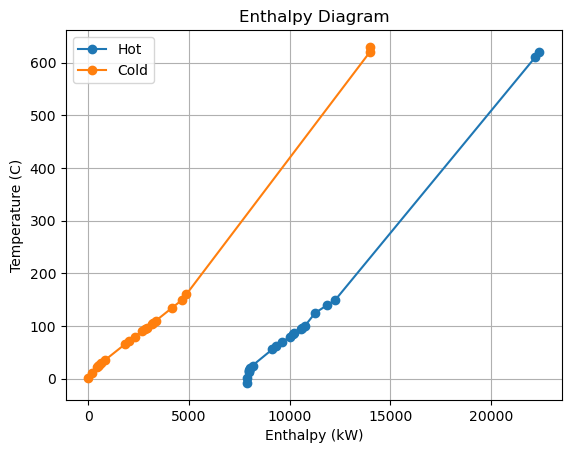

In [21]:
temperatures_hot = [2, 10.55, 23, 25, 26, 30, 35, 
                    66, 72, 80, 90, 94, 96, 104, 
                    106, 110, 135, 150, 160, 620, 630]

temperatures_cold = [i - 10 for i in temperatures_hot]


# Assuming hot_utility_results, cold_utility_results, temperatures_hot, and temperatures_cold are defined
min_cooling_requirement = 7887.27191216712

df_hot = prepare_hot_enthalpy_data(df1, temperatures_hot)
df_cold = prepare_cold_enthalpy_data(df1, min_cooling_requirement, temperatures_cold)

plot_enthalpy_diagrams(df_cold, df_hot)

In [30]:
# Assuming df_hot and df_cold are defined and have the columns 'Cumulative Utility [kW]' and 'Temperature'
max_hot_enthalpy = df_hot['Cumulative Utility [kW]'].max()
max_cold_enthalpy = df_cold['Cumulative Utility [kW]'].max()
max_enthalpy = min(max_hot_enthalpy, max_cold_enthalpy)

# Now use the max_enthalpy to limit the linspace range
refined_enthalpy = np.linspace(0, max_enthalpy, 500)  # Ensuring it is within the range

# Enable extrapolation by setting fill_value="extrapolate"
f_hot = interp1d(df_hot['Cumulative Utility [kW]'], df_hot['Temperature'], fill_value="extrapolate", bounds_error=False)
f_cold = interp1d(df_cold['Cumulative Utility [kW]'], df_cold['Temperature'], fill_value="extrapolate", bounds_error=False)


# Finding the pinch point
temperature_differences = f_hot(refined_enthalpy) - f_cold(refined_enthalpy)

# The minimum temperature difference will indicate the pinch point
min_temp_difference = np.min(temperature_differences)

pinch_point_index = np.argmin(temperature_differences)
pinch_point_enthalpy = refined_enthalpy[pinch_point_index]
pinch_point_temp_hot = f_hot(pinch_point_enthalpy)
pinch_point_temp_cold = f_cold(pinch_point_enthalpy)

print(f"Pinch Point Enthalpy: {pinch_point_enthalpy} [kW]")
print(f"Pinch Point Temperature (Cold): {pinch_point_temp_cold} [C]")
print(f"Pinch Point Temperature (Hot): {pinch_point_temp_hot} [C]")

Pinch Point Enthalpy: 8038.436272127583 [kW]
Pinch Point Temperature (Cold): 20.67385487494787 [C]
Pinch Point Temperature (Hot): 320.37623629055906 [C]


In [47]:
def plot_enthalpy_diagrams(df_hot, df_cold, pinch_point_enthalpy, pinch_point_temp_cold, pinch_point_temp_hot):
    """
    Plot enthalpy diagrams for hot and cold streams, mark the pinch points, and add a vertical dotted line at the pinch point enthalpy.
    
    Args:
    df_hot: DataFrame containing hot utility data.
    df_cold: DataFrame containing cold utility data.
    pinch_point_enthalpy: Enthalpy value at the pinch point.
    pinch_point_temp_cold: Temperature of the cold stream at the pinch point.
    pinch_point_temp_hot: Temperature of the hot stream at the pinch point.
    """
    # Plot hot and cold streams
    plt.plot(df_hot["Cumulative Utility [kW]"], df_hot["Temperature"], "-", label='Hot')
    plt.plot(df_cold["Cumulative Utility [kW]"], df_cold["Temperature"], "-", label='Cold')

    # Mark the pinch point for hot and cold streams
    plt.scatter([pinch_point_enthalpy], [pinch_point_temp_hot], color='red', label='Pinch Point - Hot')
    plt.scatter([pinch_point_enthalpy], [pinch_point_temp_cold], color='orange', label='Pinch Point - Cold')

    # Add a vertical dotted line at the pinch point enthalpy
    plt.axvline(x=pinch_point_enthalpy, color='purple', linestyle='--', label='Pinch Point Enthalpy')

    # Add labels, title, and grid
    plt.xlabel('Enthalpy (kW)')
    plt.ylabel('Temperature (C)')
    plt.title('Enthalpy Diagram with Pinch Point')
    plt.legend()
    plt.grid(True)
    plt.show()


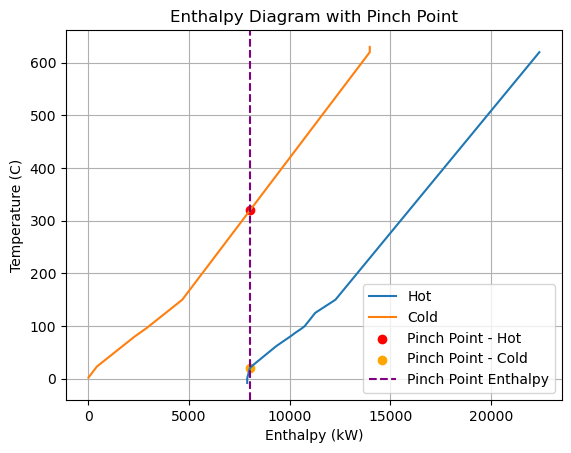

In [48]:

plot_enthalpy_diagrams(df_cold, df_hot,pinch_point_enthalpy, pinch_point_temp_cold, pinch_point_temp_hot )